# Pulsars Detection with HTRU2 Dataset


You can download the data here: [R. J. Lyon, B. W. Stappers, S. Cooper, J. M. Brooke, J. D. Knowles, Fifty Years of Pulsar
	Candidate Selection: From simple filters to a new principled real-time classification approach
	MNRAS, 2016.](https://archive.ics.uci.edu/ml/datasets/HTRU2).

## Introduction

The HTRU2 dataset contains data about pulsars. As pulsars rotate, they emit their own slightly distinct radio wave pattern that can be identified in this way by large telescopes. 

However, other radio signals are also picked up in this way. It is essential to be able to identify which waves come from pulsars and which are noise. Indeed, almost all detections in practice are caused by radio frequency interference (RFI) and noise, making legitimate signals hard to find.

The dataset contains a total of 17,897 samples of radio signals. This is an imbalanced dataset: 1,639 are real pulsar wave patterns while 16,258 are non-pulsar signals.

There are eight features in the dataset to identify the pulsars. The first four features (Mean, Standard Deviation, Excess kurtosis and Skewness) are statistics of the pulse profile wave while the last four features are statistics about the DM-SNR (Dispersion Measure - Signal-to-Noise Ratio) curve obtained through the signal.

In [8]:
import itertools

# Data analysis
import numpy as np
import pandas as pd

# Visualisation
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import seaborn as sns

# Preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Models
from sklearn.dummy import DummyClassifier
from sklearn.linear_model  import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Ensemble Models
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

# Score functions
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import matthews_corrcoef 
from sklearn.metrics import confusion_matrix

# Clustering and Principal Component Analysis
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

## 1. Data Exploration

### 1.1. Import the data

In [9]:
# Import the data
original_data = pd.read_csv("./Data/HTRU_2.csv")

# Make a copy of the data for exploration and analysis
data = original_data.copy()

# Name columns. See intro for more info on the columns
cols = [
    "Mean of the integrated profile",
    "Standard Deviation of the integrated profile",
    "Excess kurtosis of the integrated profile",
    "Skewness of the integrated profile",
    "Mean of the DM-SNR curve",
    "Standard Deviation of the DM-SNR curve",
    "Excess kurtosis of the DM-SNR curve",
    "Skewness of the DM-SNR curve",
    "Class",
]

data.columns = cols

# Remove the target variable
y_data = data["Class"]
X_data = data.drop("Class", axis=1)

### 1.2. Univariate Analysis

In [10]:
# A glance at the data
X_data.head()

,Mean of the integrated profile,Standard Deviation of the integrated profile,Excess kurtosis of the integrated profile,Skewness of the integrated profile,Mean of the DM-SNR curve,Standard Deviation of the DM-SNR curve,Excess kurtosis of the DM-SNR curve,Skewness of the DM-SNR curve
0,140.562500,55.683782,-0.234571,-0.699648,3.199833,19.110426,7.975532,74.242225
1,102.507812,58.882430,0.465318,-0.515088,1.677258,14.860146,10.576487,127.393580
2,103.015625,39.341649,0.323328,1.051164,3.121237,21.744669,7.735822,63.171909
3,136.750000,57.178449,-0.068415,-0.636238,3.642977,20.959280,6.896499,53.593661
4,88.726562,40.672225,0.600866,1.123492,1.178930,11.468720,14.269573,252.567306


In [11]:
print(f"The dataset has a shape (rows, cols) of {X_data.shape}!")

The dataset has a shape (rows, cols) of (17898, 8)!


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17898 entries, 0 to 17897
Data columns (total 9 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Mean of the integrated profile                17898 non-null  float64
 1   Standard Deviation of the integrated profile  17898 non-null  float64
 2   Excess kurtosis of the integrated profile     17898 non-null  float64
 3   Skewness of the integrated profile            17898 non-null  float64
 4   Mean of the DM-SNR curve                      17898 non-null  float64
 5   Standard Deviation of the DM-SNR curve        17898 non-null  float64
 6   Excess kurtosis of the DM-SNR curve           17898 non-null  float64
 7   Skewness of the DM-SNR curve                  17898 non-null  float64
 8   Class                                         17898 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 1.2 MB


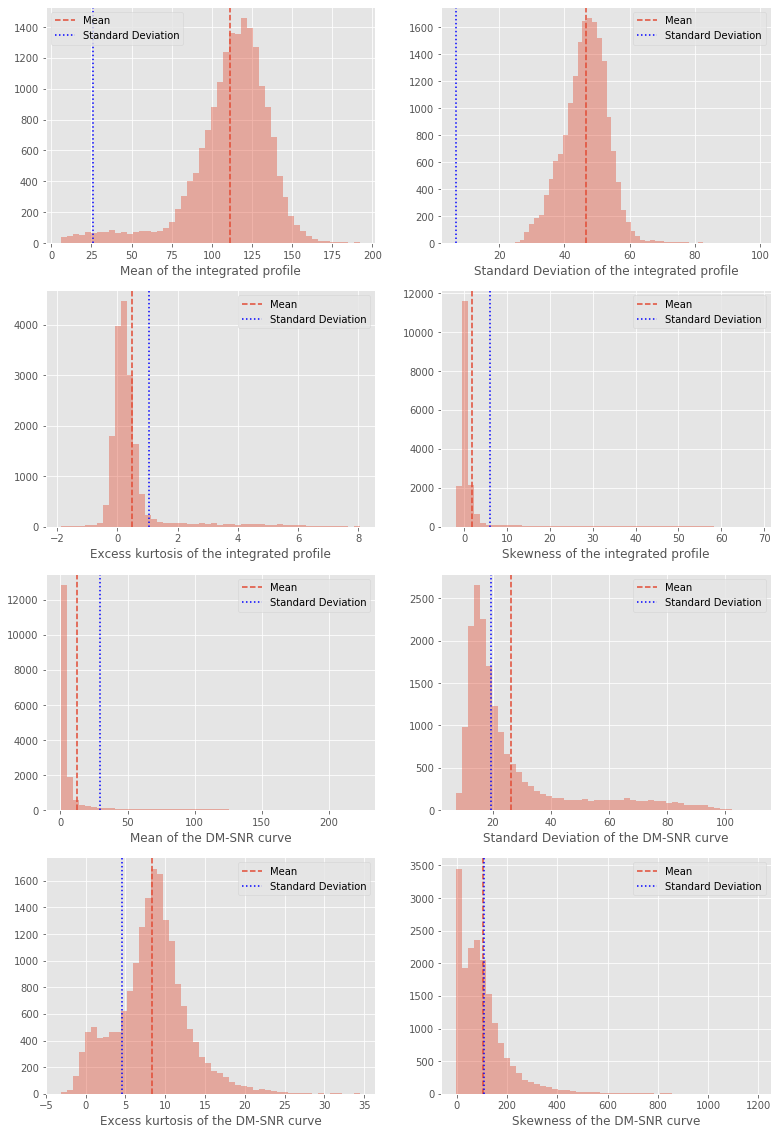

In [13]:
# Histograms to look at the distribution of data
plt.figure(figsize=(13, 20))
for i, col in enumerate(X_data.columns):
    plt.subplot(4, 2, i + 1)
    sns.distplot(X_data[col], kde=False)
    plt.axvline(X_data[col].mean(), linestyle="dashed", label="Mean")
    plt.axvline(
        X_data[col].std(), color="b", linestyle="dotted", label="Standard Deviation"
    )
    plt.legend(loc="best")

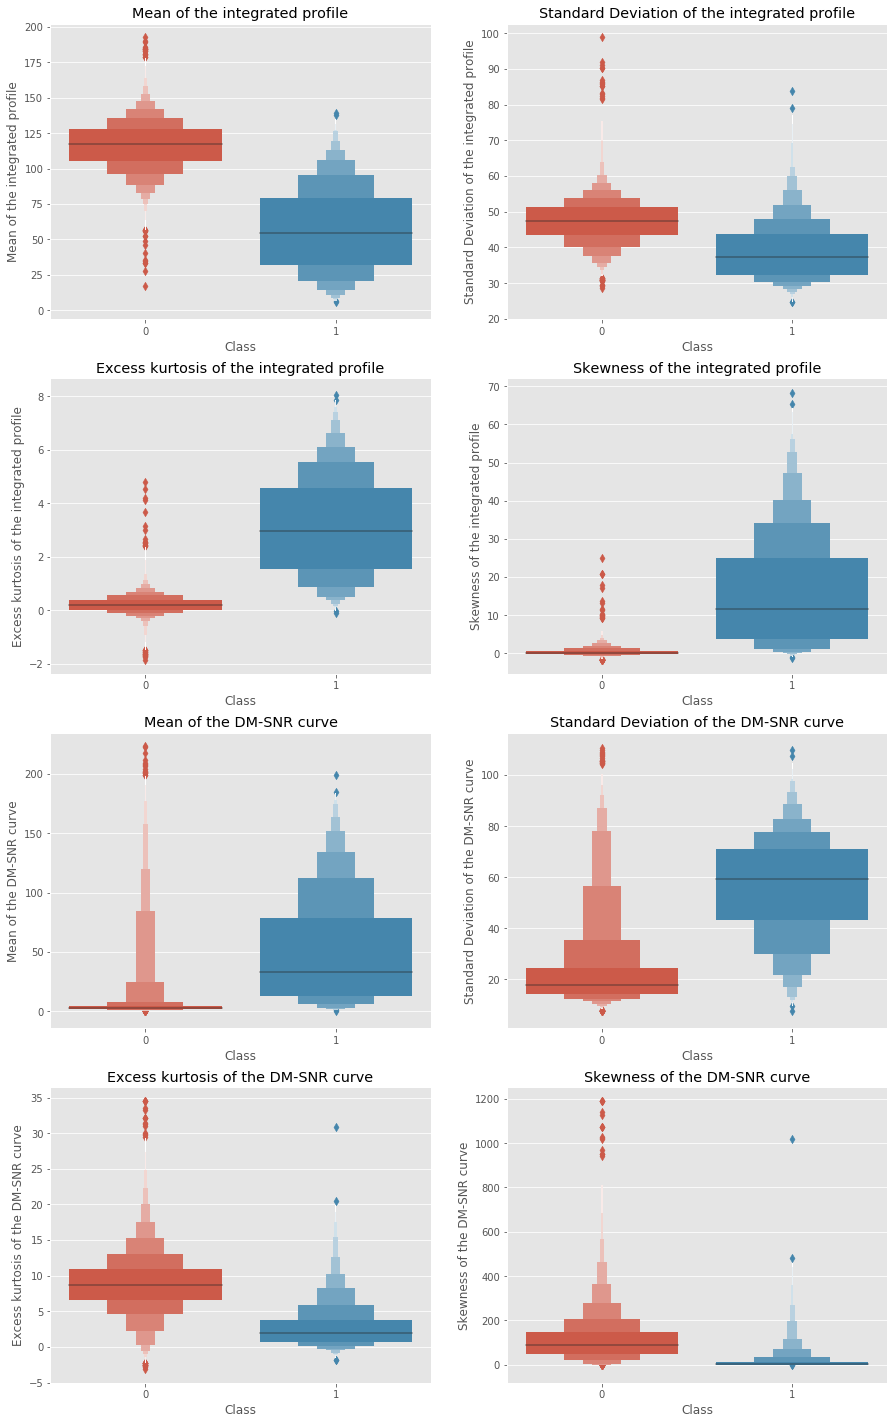

In [14]:
# Visual representation of the statistical summary of data
# Boxenplot shows a large number of quantiles
plt.figure(figsize=(15, 25))
for i, col in enumerate(X_data.columns):
    plt.subplot(4, 2, i + 1)
    sns.boxenplot(x=y_data, y=X_data[col])
    plt.title(col)

## 1.3. Bivariate analysis

Finding correlation between variables provides insights about the relationship between them.

The objective is to determine whether two measurement variables covary, and to quantify the strength of the relationship between them.

Text(0.5, 1, 'Correlation between Variables')

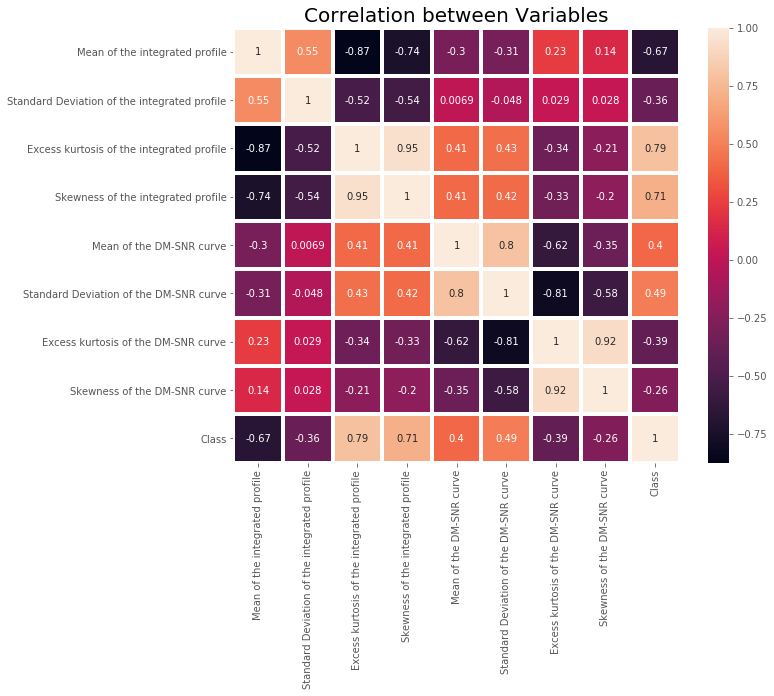

In [15]:
heat_map = data.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(heat_map, annot=True, linewidth=3)
plt.title("Correlation between Variables", fontsize=20)

Insights drawn from variables' analysis is important, including for feature selection.

It allows for a more accurate predictive model, by choosing features contributing to a good or even better accuracy with less data. 

Given our lack of domain knowledge, we will keep all features for the rest of the analysis. However, dimensionality reduction by applying Principal Component Analysis will be investigated in part 4.

## 2. Data Preparation

The dataset is clean: there are no missing values and we only have numerical data.

However, some feature scaling seems useful here. Normalization will convert the range of values into a standard range of values.

As with all transformations, it is important to fit the scaler to the training data only, and not to the full dataset. Only then will the StandardScaler be applied to both the training and the test sets.

Let's first split the dataset into a train set and a test set.

In [16]:
# Split the dataset into a train test and a test set
X_train, X_test, y_train, y_test = train_test_split(
    X_data, y_data, test_size=0.2, random_state=0
)

In [17]:
# Fit the StandardScaler to the train set
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_data.columns)

# Transform the test set
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_data.columns)

## 3. Classification Models

### 3.1. Choosing a metric

Picking an appropriate metric is an essential yet challenging part of any data science project.

If we pick a metric not suited for the evaluation of our models, we could be led to choose a wrong model, whose generalization ability is poorer than expected. 

Picking an appropriate metric is all the more difficult when dealing with imbalanced datasets, as this Pulsars datasat. 

For illustration purposes, let's use a dummy classifier that labels all instances as negative (0) to see how common classification metrics should not be used with an imbalanced dataset as they are misleading about the actual performance of the model.

In [18]:
# Creating a dummy classifier
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
dummy_y_pred = dummy.predict(X_test)

# Dummy classifier performance
print(
    "Precision: ",
    precision_score(
        y_test, dummy_y_pred, average="weighted", labels=np.unique(dummy_y_pred)
    ),
)
print(
    "F1 Score: ",
    f1_score(y_test, dummy_y_pred, average="weighted", labels=np.unique(dummy_y_pred)),
)
print(
    "Recall: ",
    recall_score(
        y_test, dummy_y_pred, average="weighted", labels=np.unique(dummy_y_pred)
    ),
)

Precision:  0.923463687150838
F1 Score:  0.960209119953529
Recall:  1.0


We get between 90 and 100 % for all metrics! These metrics clearly give us false assumptions regarding the classifier's performance. What should we do?

We will use a lesser-known but elegant scalar metrics: the Matthews correlation coefficient (MCC).

MCC = $\frac{TP*TN-FP*FN}{\sqrt{(TP+FP)*(FN+TN)*(FP+TN)*(TP+FN)}}$

**TP** = True Positive, **TN** = True Negative, **FP** = False Positive, **FN** = False Negative 

According to [Wikipedia](https://en.wikipedia.org/wiki/Matthews_correlation_coefficient):

*“The Matthews correlation coefficient is used in machine learning as a measure of the quality of binary (two-class) classifications. It takes into account true and false positives and negatives and is generally regarded as a balanced measure which can be used even if the classes are of very different sizes. The MCC is in essence a correlation coefficient value between -1 and +1. A coefficient of +1 represents a perfect prediction, 0 an average random prediction and -1 an inverse prediction. The statistic is also known as the phi coefficient.”*

In [19]:
# Function to calculate and plot metrics
def print_metrics(y_test, y_pred):

    print("\033[1mMatthews Correlation Coefficient:", matthews_corrcoef(y_test, y_pred))

    print("\nClassification report:\n", (classification_report(y_test, y_pred)))

    plt.figure(figsize=(6, 4))
    sns.heatmap(
        confusion_matrix(y_test, y_pred),
        annot=True,
        fmt="d",
        linecolor="k",
        linewidths=3,
    )
    plt.title("Confusion Matrix", fontsize=20)

In [20]:
# Creating a Pandas DataFrame to retain models' performance
performance = pd.DataFrame(index=["MCC", "F1 Score"])

**Note**: we could also have been addressing the problem of class imbalance by oversampling the dataset, for example using Synthetic minority oversampling technique (SMOTE).

### 3.2. Quick-and-dirty models

#### Logistic Regression

Matthews Correlation Coefficient: 0.8773093424879191

Classification report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      3306
           1       0.93      0.84      0.89       274

    accuracy                           0.98      3580
   macro avg       0.96      0.92      0.94      3580
weighted avg       0.98      0.98      0.98      3580



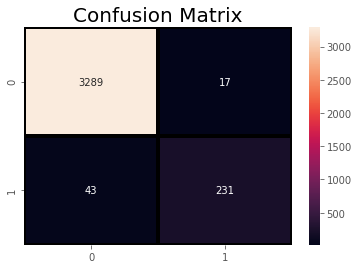

In [21]:
# Fitting the model and predicting
log_reg = LogisticRegression()
log_reg.fit(X_train, y_train)
log_reg_pred = log_reg.predict(X_test)

# A glance at the performance (different metrics)
print_metrics(y_test, log_reg_pred)

# Keep model's performance for later comparison
performance["Logistic Regression"] = (
    matthews_corrcoef(y_test, log_reg_pred),
    f1_score(y_test, log_reg_pred),
)

#### K-Nearest Neighbors

Matthews Correlation Coefficient: 0.8881798475270369

Classification report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      3306
           1       0.93      0.86      0.90       274

    accuracy                           0.98      3580
   macro avg       0.96      0.93      0.94      3580
weighted avg       0.98      0.98      0.98      3580



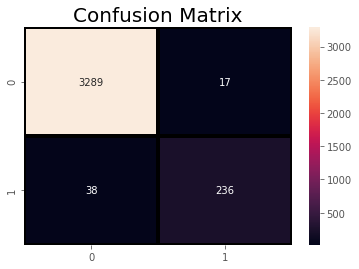

In [22]:
# Fitting the model and predicting
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
knn_pred = knn.predict(X_test)

# A glance at the performance (different metrics)
print_metrics(y_test, knn_pred)

# Keep model's performance for later comparison
performance["K-Nearest Neighbors"] = (
    matthews_corrcoef(y_test, knn_pred),
    f1_score(y_test, knn_pred),
)

#### Decision Tree Classifier

Matthews Correlation Coefficient: 0.8149392210233223

Classification report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      3306
           1       0.81      0.85      0.83       274

    accuracy                           0.97      3580
   macro avg       0.90      0.92      0.91      3580
weighted avg       0.97      0.97      0.97      3580



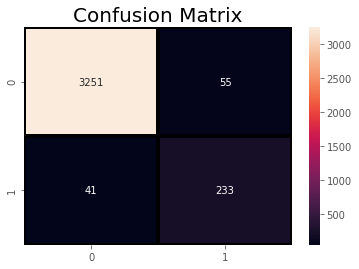

In [23]:
# Fitting the model and predicting
tree = DecisionTreeClassifier(criterion="entropy")
tree.fit(X_train, y_train)
tree_pred = tree.predict(X_test)

# A glance at the performance (different metrics)
print_metrics(y_test, tree_pred)

# Keep model's performance for later comparison
performance["Decision Tree"] = (
    matthews_corrcoef(y_test, tree_pred),
    f1_score(y_test, tree_pred),
)

#### Naïve Bayes

Matthews Correlation Coefficient: 0.7282604381580652

Classification report:
               precision    recall  f1-score   support

           0       0.99      0.96      0.97      3306
           1       0.65      0.87      0.74       274

    accuracy                           0.95      3580
   macro avg       0.82      0.91      0.86      3580
weighted avg       0.96      0.95      0.96      3580



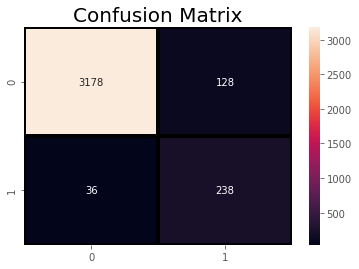

In [24]:
# Fitting the model and predicting
bayes = GaussianNB()
bayes.fit(X_train, y_train)
bayes_pred = bayes.predict(X_test)

# A glance at the performance (different metrics)
print_metrics(y_test, bayes_pred)

# Keep model's performance for later comparison
performance["Naïve Bayes"] = (
    matthews_corrcoef(y_test, bayes_pred),
    f1_score(y_test, bayes_pred),
)

#### Support Vector Classifier

Matthews Correlation Coefficient: 0.8734243723221742

Classification report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      3306
           1       0.92      0.84      0.88       274

    accuracy                           0.98      3580
   macro avg       0.96      0.92      0.94      3580
weighted avg       0.98      0.98      0.98      3580



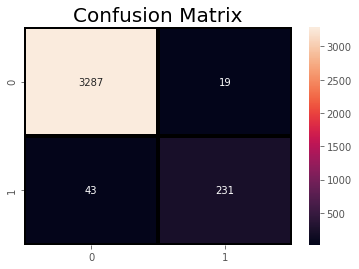

In [25]:
# Fitting the model and predicting
svc = SVC()
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)

# A glance at the performance (different metrics)
print_metrics(y_test, svc_pred)

# Keep model's performance for later comparison
performance["SVC"] = matthews_corrcoef(y_test, svc_pred), f1_score(y_test, svc_pred)

Let's compare our models' performance with regards to our chosen metric:

In [26]:
def performance_plot(performance):
    """Barplots of each model's performance on the Matthews Correlation Coefficient (MCC) and the F1 Score"""
    fig, ax = plt.subplots(figsize=(15, 7))
    w = 0.4
    i = np.arange(len(performance.columns))
    models = performance.columns

    bars_left = ax.bar(i - w / 2, performance.loc["MCC"] * 100, width=w, label="MCC")
    bars_right = ax.bar(
        i + w / 2, performance.loc["F1 Score"] * 100, width=w, label="F1 Score"
    )

    ax.grid(axis="y")
    ax.set_xticks(i)
    ax.set_xticklabels(models)
    ax.set_ylabel("Ratio (%)")
    ax.legend(loc="best")
    ax.set_ylim(0, 100)
    ax.set_title("Models performance")
    for bar in itertools.chain(bars_left, bars_right):
        height = bar.get_height()
        ax.annotate(
            "{:4.1f}".format(height),
            xy=(bar.get_x() + bar.get_width() / 2, height),
            xytext=(0, 3),
            textcoords="offset points",
            ha="center",
        )

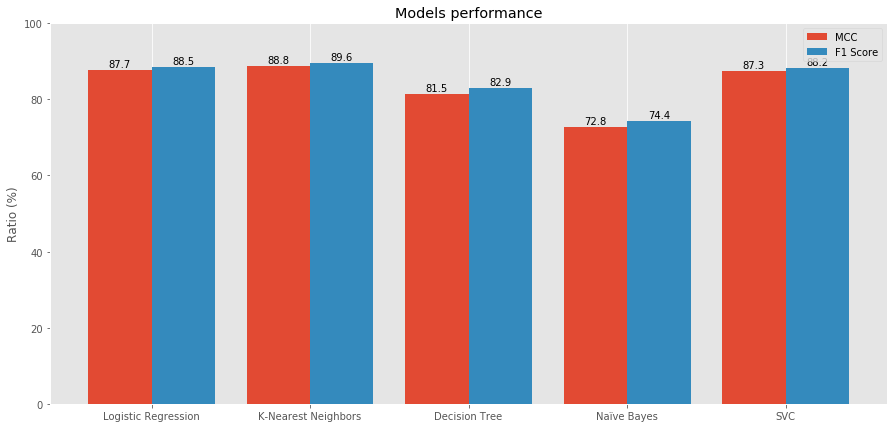

In [27]:
# Plotting each model's performances
performance_plot(performance)

### 3.3. Ensemble learning

Ensemble learning is a model that makes predictions on the basis of a number of different models. By combining in various ways simpler models, the ensemble model is usually more flexible (less bias) and less data-sensitive (less variance).

There are three main ensemble methods. We will train a model for each method as illustration.

**Bagging**: model learning from **homogeneous** weak learners that are learnt independently from each other, in parallel. The model then combines them by using a predetermined deterministic averaging process.

**Boosting**: model learning from  **homogeneous** weak learners that are learnt sequentially in an adaptative way (a base model depends on the previous ones). The model then combines them following a predetermined deterministic strategy.

**Stacking**: model learning from **heterogeneous** weak learners that are learnt in parallel. The model then combines them by training a meta-model to output a prediction based on the different weak learner's predictions (for example using Logistic Regression).

#### 3.3.1. Bagging

**Random forest** is an ensemble model using **bagging** as the ensemble method and decision tree as the individual model.

It uses bagging and feature randomness when building each individual tree to create an uncorrelated forest of trees whose prediction by committee is more accurate than that of any individual tree.

Matthews Correlation Coefficient: 0.8819062619687832

Classification report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      3306
           1       0.93      0.85      0.89       274

    accuracy                           0.98      3580
   macro avg       0.96      0.92      0.94      3580
weighted avg       0.98      0.98      0.98      3580



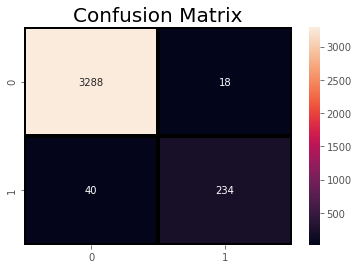

In [28]:
# Fitting the model and predicting
rand_forest = RandomForestClassifier(n_jobs=-1)
rand_forest.fit(X_train, y_train)
rand_forest_pred = rand_forest.predict(X_test)

# A glance at the performance (different metrics)
print_metrics(y_test, rand_forest_pred)

# Keep model's performance for later comparison
performance["Random Forest"] = (
    matthews_corrcoef(y_test, rand_forest_pred),
    f1_score(y_test, rand_forest_pred),
)

#### 3.3.2. Boosting

**AdaBoost** is a **boosting** ensemble model and works especially well with the decision tree. Boosting model’s key is learning from the previous mistakes, e.g. misclassification data points.

AdaBoost learns from the mistakes by increasing the weight of misclassified data points.

Matthews Correlation Coefficient: 0.8843306657297987

Classification report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      3306
           1       0.93      0.86      0.89       274

    accuracy                           0.98      3580
   macro avg       0.96      0.93      0.94      3580
weighted avg       0.98      0.98      0.98      3580



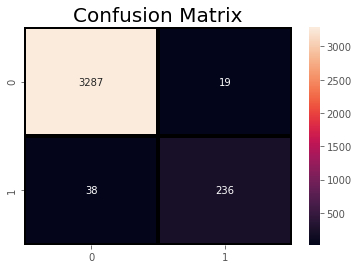

In [29]:
# Fitting the model and predicting
tree = DecisionTreeClassifier(criterion="entropy", max_depth=1)

adaboost = AdaBoostClassifier(
    base_estimator=tree, n_estimators=500, learning_rate=0.1, random_state=42
)
adaboost.fit(X_train, y_train)
adaboost_pred = adaboost.predict(X_test)

# A glance at the performance (different metrics)
print_metrics(y_test, adaboost_pred)

# Keep model's performance for later comparison
performance["AdaBoost"] = (
    matthews_corrcoef(y_test, adaboost_pred),
    f1_score(y_test, adaboost_pred),
)

#### 3.3.3. Stacking

Scikit-learn's **StackingClassifier** consists in **stacking** the output of individual estimator and using a classifier (by default Logistic Regression) to compute the final prediction.

Matthews Correlation Coefficient: 0.8860136373094334

Classification report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      3306
           1       0.93      0.86      0.89       274

    accuracy                           0.98      3580
   macro avg       0.96      0.93      0.94      3580
weighted avg       0.98      0.98      0.98      3580



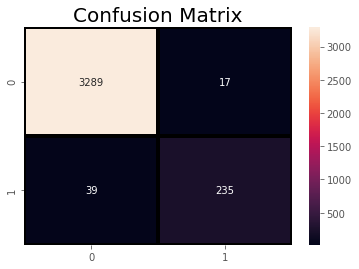

In [30]:
# Fitting the model and predicting
estimators = [
    ("knn", knn),
    ("tree", tree),
    ("logreg", log_reg),
    ("svc", svc),
    ("nb", bayes),
]
stack = StackingClassifier(estimators=estimators)
stack.fit(X_train, y_train)
stack_pred = stack.predict(X_test)

# A glance at the performance (different metrics)
print_metrics(y_test, stack_pred)

# Keep model's performance for later comparison
performance["Stacking"] = (
    matthews_corrcoef(y_test, stack_pred),
    f1_score(y_test, stack_pred),
)

Let's check how our ensemble models compare to our vanilla models:

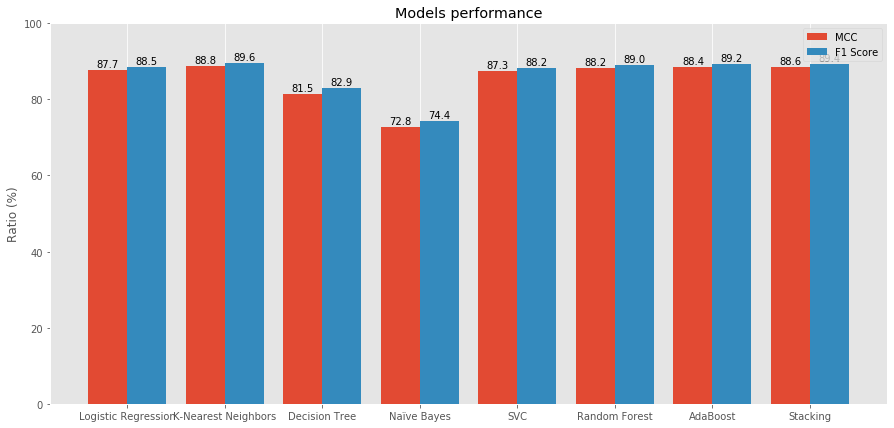

In [32]:
# Plotting each model's performances
performance_plot(performance)

Our best estimator is the Random Forest Classifier: 

- **Matthew's Correlation Coefficient**: 0.886
- **F1 Score**: 0.894

**Note**: let's keep in mind that our vanilla and ensemble models have not been optimized with hyperparameter tuning, and that consequently their potential for improvement is high.

## 4. Clustering with K-Means

For a detailed explanation and overview of the K-Means algorithm, see my Project ["Clustering with K-Means"](https://github.com/ThomasDelatte/Clustering_with_K-Means).

Finding clusters in a high-dimensional space (even though our dataset contains "only" 8 features) may require a lot of data to train the model.

Moreover, multiple dimensions are hard to think in and are impossible to visualize. The concept of Euclidean distance becomes less useful as the number of dimensions increases, since the distance between any two data points converges. 

This problem is known as the curse of dimensionality.

Both Principal Component Analysis (PCA) and clustering seek to simplify the data, but their mechanisms are different: 

* PCA: finds a low-dimensional representation of the data that explain a sufficient part of the variance.
* Clustering: finds homogeneous subgroups among the data.

### 4.1. Principal Component Analysis

PCA assumes that the dataset is centered around the origin. It has been done earlier when standardizing the data.

In [33]:
# Apply PCA on both datasets
X_for_pca = X_train.append(X_test, ignore_index=True)

# Principal Component Analysis with the 8 dimensions (features) of the dataset
pca = PCA(n_components=8)
pca.fit_transform(X_for_pca)

# We can now retrieve the important information
print(pca.explained_variance_ratio_)

[0.51503339 0.26920073 0.10191216 0.05748074 0.0318951  0.01992676
 0.00251496 0.00203617]


Text(0.5, 1.0, 'Pulsars Dataset - Explained Variance')

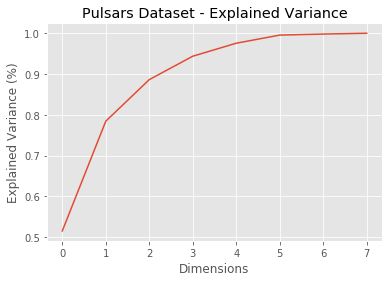

In [34]:
# Plotting the Cumulative Summation of the Explained Variance
plt.figure()
sns.lineplot(data=np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance (%)")
plt.title("Pulsars Dataset - Explained Variance")

We can see that only 2 dimensions explain 78% of the variance. We see indeed an elbow in the curve after the second dimension (which would be even more prominent with the full y-axis).

Let's create reduced data based on these two dimensions and plot them.

We should note that after dimensionality reduction, there is usually no particular meaning assigned to each principal component. The new components are just the two main dimensions of variation.

In [35]:
# Create a reduced 2-dimensional dataset
pca = PCA(n_components=2)
X_reduced = pd.DataFrame(
    pca.fit_transform(X_for_pca),
    columns=["Principal Component 1", "Principal Component 2"],
)

In [36]:
X_reduced.head()

,Principal Component 1,Principal Component 2
0,0.275008,-1.098496
1,-0.579306,-0.232299
2,3.526667,-2.110634
3,0.776626,1.033537
4,-0.776421,0.703410


### 4.2. Clustering with K-Means


In [37]:
# Use SKLearn algorithm on the dataset
kmeans = KMeans(n_clusters=2)
kmeans.fit(X_reduced)
clusters = kmeans.predict(X_reduced)

# Identify the centroids
centers_pulsars = kmeans.cluster_centers_

Text(0.5, 1.0, 'K-means clustering with PCA-reduced data')

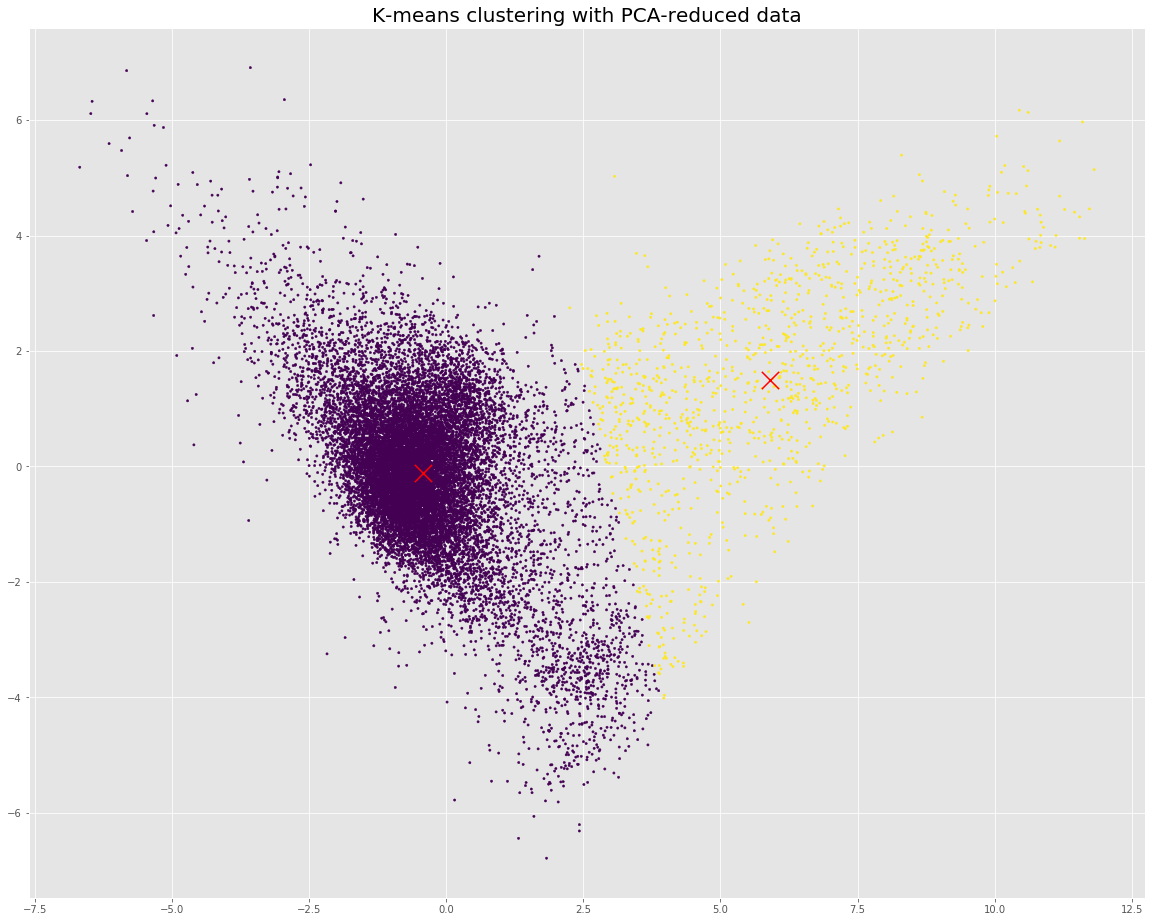

In [38]:
def plot_clusters(X, clusters=None, centers=None):
    # Plot the data points
    plt.scatter(X[:, 0], X[:, 1], c=clusters, s=5, cmap="viridis")

    # Plot the centers if they are identified
    if np.any(centers):
        plt.scatter(
            centers[:, 0], centers[:, 1], marker="x", s=300, linewidths=10, color="r"
        )


# Transform into a NumPy array for plotting
X_plot = np.array(X_reduced)

# Plotting the results of k-means clustering
plt.figure(figsize=[20, 16])
plot_clusters(X_plot, clusters=clusters, centers=centers_pulsars)
plt.title("K-means clustering with PCA-reduced data", fontsize=20)

We can see a clear linear delimitation between the two clusters. Do these clusters match the Pulsar classes? 

Let's find out.

### 4.3. K-Means Clusters for Classification?

Matthews Correlation Coefficient: 0.007534607248332099

Classification report:
               precision    recall  f1-score   support

           0       0.91      0.93      0.92     16259
           1       0.10      0.07      0.09      1639

    accuracy                           0.85     17898
   macro avg       0.50      0.50      0.50     17898
weighted avg       0.83      0.85      0.84     17898



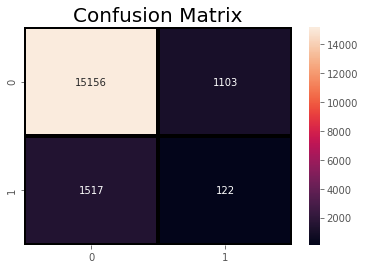

In [39]:
# Assign a label (0 and 1) to each point depending on their identified cluster
kmeans_pred = pd.DataFrame(kmeans.labels_)

# A glance at the performance (different metrics)
print_metrics(y_data, kmeans_pred)

# Keep performance for later comparison
performance["K-means"] = (
    matthews_corrcoef(y_data, kmeans_pred),
    f1_score(y_data, kmeans_pred),
)

Now, compared to the other models: 

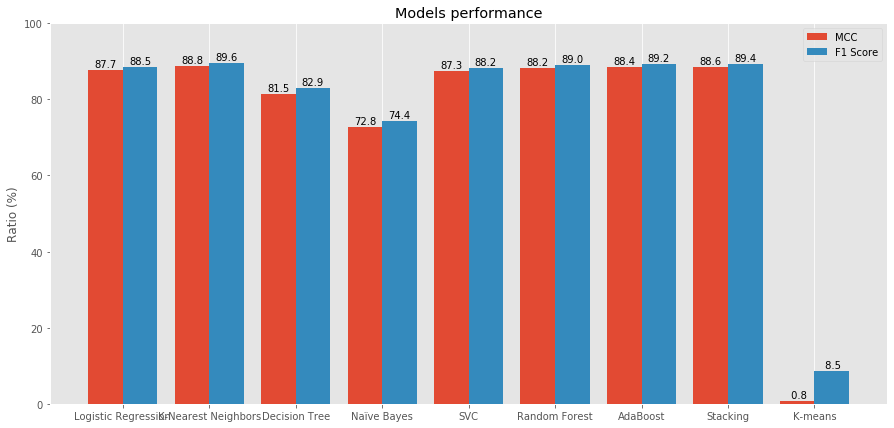

In [40]:
# Let's compare this poor performance to our other models
performance_plot(performance)

K-Means performance is very bad: Matthews Correlation Coefficient is close to 0, meaning that it is close to an average random prediction.

This is probably due to the reduction of information through PCA, as well as the inadequacy of k-means for reliable classification.

## Final note

Even though our best classifier could obviously be improved upon, the goal was to go through each stage of a small machine learning project. As with most of data science, the bulk of the work will go into testing and tuning hyperparameters, as well as feature engineering to improve the model.